## <center style="color:red;">**BrainScan – Détection du Cancer Cérébral par CNN**</center>

Ce projet vise à développer un modèle de Deep Learning capable de classer les images IRM cérébrales afin de détecter le cancer du cerveau avec précision. Il combine CNN, TensorFlow/Keras et OpenCV pour offrir une solution rapide, fiable et utile à l’aide au diagnostic médical.

<br>

### <span style="color:green;">**Chargement et Prétraitement du Dataset :**</span>

#### <span style="color:blue;">**1. Importer les bibliothèques nécessaires :**</span>

In [246]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import cv2

#### <span style="color:blue;">**2. Chargement des Images et Vérification des Extensions :**</span>

**Définir les chemins pour le fichier ZIP et le dossier de décompression :**

In [249]:
zip_path = "../data/zip/Data.zip"
unziped_path = "../data/unziped"

**Décompresser le ZIP si le fichier existe :**

In [250]:
if os.path.exists(zip_path) :
    print(f"Décompression de {zip_path} vers {unziped_path} :")
    with zipfile.ZipFile(zip_path, 'r') as z :
        if os.path.exists(unziped_path) :
            z.extractall(unziped_path)
        else :
            print(f"{unziped_path} Non Trouvé !")
    print("Décompression Terminée.")
else :
    print(f"{zip_path} Non Trouvé !")

Décompression de ../data/zip/Data.zip vers ../data/unziped :
Décompression Terminée.


**Trouver toutes les classes (dossiers/sous-dossiers) :**

In [251]:

classes = []

for d in sorted(os.listdir(unziped_path)) :
    for sub_d in sorted(os.listdir(f"{unziped_path}/{d}")) :
        if os.path.isdir(os.path.join(unziped_path, d, sub_d)):
            classes.append(f"{d}/{sub_d}")

print("classes = ",classes)

classes =  ['Data/glioma', 'Data/meningioma', 'Data/notumor', 'Data/pituitary']


**Définir les extensions d'image autorisées :**

In [252]:
allowed_extensions = ['jpeg', 'jpg', 'bmp', 'png']

# Listes pour stocker les images et leurs labels
images = []
labels = []

**Parcourir chaque classe et charger les images et Supprimer les fichiers avec extensions non autorisées :**

In [253]:
for c in classes :
    
    dir_path = os.path.join(unziped_path, c)

    for img in os.listdir(dir_path) :
        img_path = os.path.join(dir_path, img)

         # Vérifier que c'est un fichier
        if os.path.isfile(img_path) :

            # Récupérer l'extension en minuscule
            img_extension = img.split('.')[1].lower()
            
            if img_extension in allowed_extensions :
                try :
                    # Lire l'image avec OpenCV
                    pic = cv2.imread(img_path)
                    if pic is not None :
                        images.append(pic)              # Ajouter l'image à la liste
                        lbl = str(c.split('/')[1])      # Extraire le label de la sous-classe
                        labels.append(lbl)              # Ajouter le label correspondant
                    else:
                        print(f"Impossible de lire l'image : {img_path}")
                except Exception as e :
                     # Gérer toute erreur de lecture et afficher un message
                    print(f"Erreur lors de la lecture de {img_path} : {e}")
            else :
                # Supprimer le fichier si l'extension n'est pas autorisée
                os.remove(img_path)

In [254]:
print(f"- {len(images)} Images.")
print(f"- {len(labels)} Labels.")

- 7023 Images.
- 7023 Labels.


#### <span style="color:blue;">**2. Exploration et Visualisation des Classes du Dataset :**</span>

**Identifier les classes (dossiers) présentes dans le dataset :**

In [255]:
labels_uniques = []

for c in labels:
    if c not in labels_uniques:
        labels_uniques.append(c)

print(labels_uniques)

['glioma', 'meningioma', 'notumor', 'pituitary']


**Compter le nombre d’images par classe :**

In [256]:
images_par_label = {}

for lbl in labels:
    if lbl in images_par_label:
        images_par_label[lbl] += 1
    else:
        images_par_label[lbl] = 1

for classe, nombre in images_par_label.items():
    print(f"- {classe} : {nombre} images")


- glioma : 1621 images
- meningioma : 1645 images
- notumor : 2000 images
- pituitary : 1757 images


**Visualiser quelques échantillons d’images de chaque classe :**

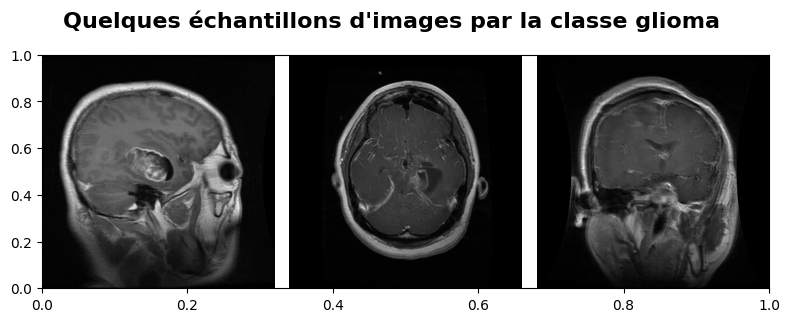

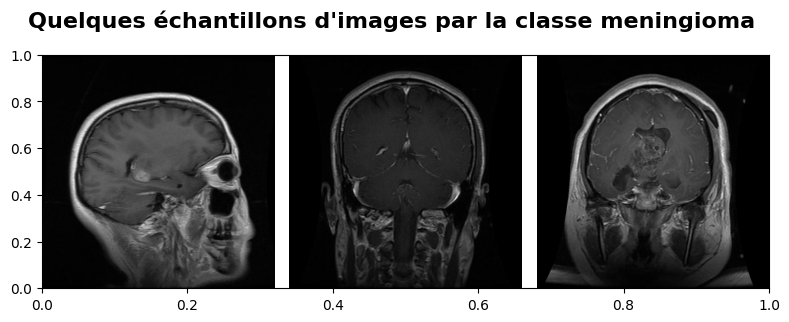

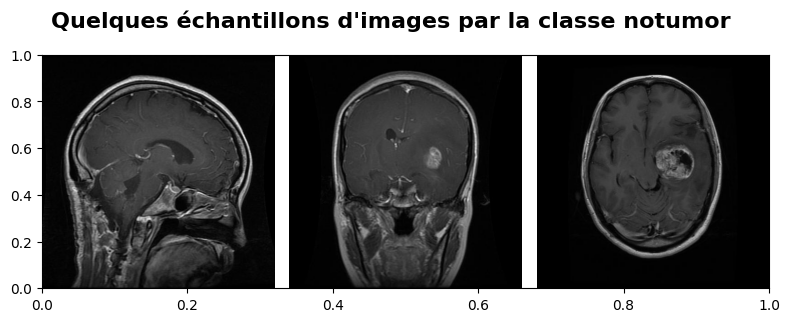

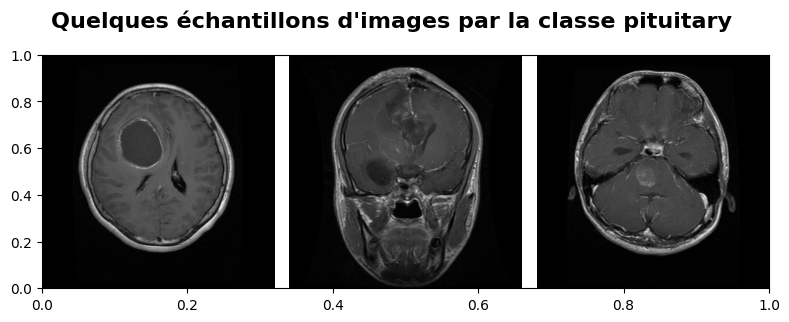

In [258]:
import random

labels_uniques = sorted(list(set(labels)))

indices = []

for indice, label in enumerate(labels_uniques) :
    
    plt.subplots(figsize=(8, 3))

    for idx, lbl in enumerate(labels) :
        if lbl == labels_uniques[0] :
            indices.append(idx)
        
    echantillon = random.sample(indices, 3)

    for i, j in enumerate(echantillon) :
        plt.subplot(1, 3, i+1)

        img_rgb = cv2.cvtColor(images[j], cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis("off")

    plt.suptitle(f"Quelques échantillons d'images par la classe {label} ", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    

**Générer un graphique montrant la distribution des classes :**

<function matplotlib.pyplot.show(close=None, block=None)>

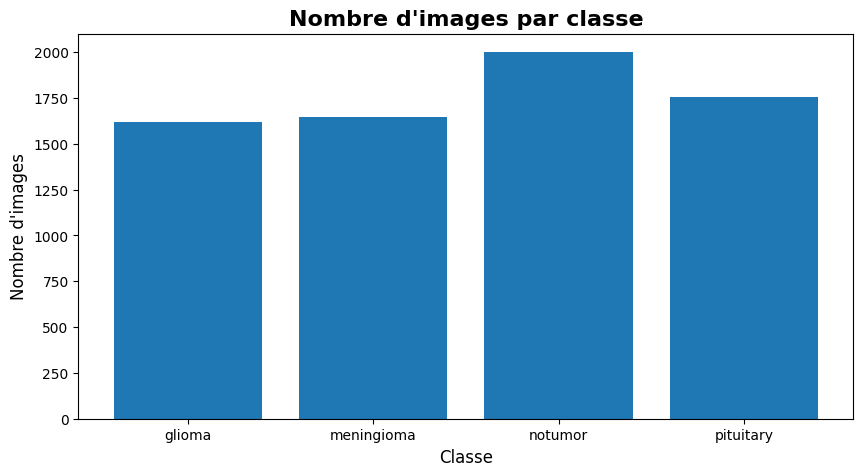

In [259]:
noms_labels = []
nb_images = []

for k, v in images_par_label.items() :
    noms_labels.append(k)
    nb_images.append(v)


plt.figure(figsize=(10,5))
plt.bar(noms_labels, nb_images)
plt.title("Nombre d'images par classe", fontsize=16, fontweight='bold')
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Nombre d'images", fontsize=12)

plt.show

#### <span style="color:blue;">**3. Préparation des Données pour le Modèle CNN :**</span>

**Mélanger les images et les étiquettes dans deux listes synchronisées :**

In [260]:
if len(images) == len(labels) :
    indices = list(range(len(images)))
    
    random.shuffle(indices)

    images = [images[i] for i in indices]
    labels = [labels[i] for i in indices]

**Redimensionner les images (224×224) avec OpenCV :**

In [261]:
size = (224, 224)

resized_images = []

for img in images :
    try :
        if img is not None :
            resized = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
            resized_images.append(resized)
        else :
            print("Image Vide !")
    except Exception as e :
        print(f"Erreur lors du redimensionnement de l'image : {e}")

**Convertir les listes en tableaux NumPy :**

In [262]:
X = np.array(resized_images, dtype=np.float32) 

y = np.array(labels)

print("Conversion en tableaux NumPy réussie !")
print("Forme de X :", X.shape)
print("Type de X :", X.dtype)
print("Nombre de labels :", len(y))

Conversion en tableaux NumPy réussie !
Forme de X : (7023, 224, 224, 3)
Type de X : float32
Nombre de labels : 7023


**Appliquer un rééquilibrage si les classes sont déséquilibrées :**

In [263]:
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

max_count = max(images_par_label.values())

augmented_images = []
augmented_labels = []

indices_cls=[]
images_cls=[]

for cls in labels_uniques:

    indices_cls = [i for i, lbl in enumerate(labels) if lbl == cls]
    images_cls = [resized_images[i] for i in indices_cls]

    nbr_to_generate = max_count - len(images_cls)

    
    if nbr_to_generate == 0:
        augmented_images.extend(images_cls)
        augmented_labels.extend([cls]*len(images_cls))
        continue

    augmented_images.extend(images_cls)
    augmented_labels.extend([cls]*len(images_cls))


    i = 0
    while nbr_to_generate > 0:
        img = images_cls[i % len(images_cls)]
        img_exp = np.expand_dims(img, 0) 
        for batch in datagen.flow(img_exp, batch_size=1):
            augmented_images.append(batch[0].astype(np.uint8))
            augmented_labels.append(cls)
            nbr_to_generate -= 1
            break 
        i += 1

images_balanced = np.array(augmented_images, dtype=np.float32)
labels_balanced = np.array(augmented_labels)

print("Après Augmentation :")
print("Nombre total d'images :", images_balanced.shape[0])

images = images_balanced
labels = labels_balanced

images_par_label = {}

for lbl in labels:
    if lbl in images_par_label:
        images_par_label[lbl] += 1
    else:
        images_par_label[lbl] = 1

for classe, nombre in images_par_label.items():
    print(f"- {classe} : {nombre} images")

Après Augmentation :
Nombre total d'images : 8000
- glioma : 2000 images
- meningioma : 2000 images
- notumor : 2000 images
- pituitary : 2000 images


<function matplotlib.pyplot.show(close=None, block=None)>

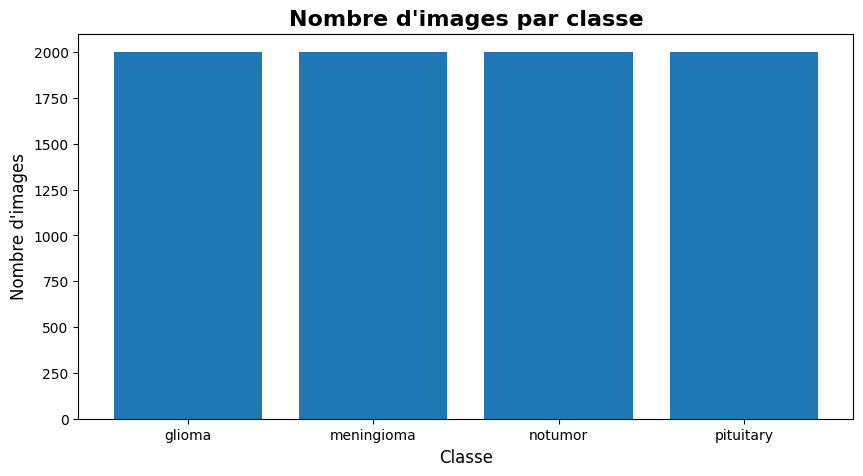

In [264]:
noms_labels = []
nb_images = []

for k, v in images_par_label.items() :
    noms_labels.append(k)
    nb_images.append(v)


plt.figure(figsize=(10,5))
plt.bar(noms_labels, nb_images)
plt.title("Nombre d'images par classe", fontsize=16, fontweight='bold')
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Nombre d'images", fontsize=12)

plt.show

**Transformer les labels en format numérique (LabelEncoder et to_categorical) :**

In [280]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

labels_categorical = tf.keras.utils.to_categorical(labels_encoded)

labels_categorical[:5]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

**Diviser le dataset en ensembles d’entraînement et de test :**

In [281]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    images_balanced,
    labels_categorical, 
    test_size=0.2,
    random_state=42,
    shuffle=True
)

**Normaliser les valeurs des pixels dans la plage [0, 1] :**

In [282]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0